## Работу выполнил Осинский А.  группа - ПМ23-2


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import itertools


## Предобработка Данных

In [21]:



file_path = 'econometricsHW2.xlsx'  


try:
    df = pd.read_excel(file_path, header=[0, 1])
    print("Данные успешно загружены.")
except FileNotFoundError:
    print("Файл не найден. Убедитесь, что указали правильный путь к файлу.")
    df = None
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")
    df = None

if df is not None:
    # Просмотр первых 5 строк данных
    print("\nПервые 5 строк данных:")
    print(df.head())
    
    # Проверка типа столбцов
    print("\nТип столбцов:")
    print(df.columns)
    
    # Проверка, является ли df.columns MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        print("\nСтолбцы являются MultiIndex. Выполняем объединение уровней заголовков.")
        # Объединение уровней MultiIndex в одно имя столбца с пробелом
        df.columns = [' '.join([str(i) for i in col]).strip() for col in df.columns.values]
        print("Новые названия столбцов после объединения:")
        print(df.columns.tolist())
    else:
        print("\nСтолбцы являются обычным Index.")
    
    
    print("\nКолонки до очистки:")
    print(df.columns.tolist())
    
    
    df.columns = df.columns.str.replace(r'\s+', ' ', regex=True)
    
   
    df.columns = df.columns.str.replace(r'\s+[XYА-Яа-я]+\d*\.?\d*$', '', regex=True)
    
    
    print("\nКолонки после очистки:")
    print(df.columns.tolist())
    
   
    numeric_columns = [
        'Прибыль (убыток)', 
        'Долгосрочные обязательства', 
        'Краткосрочные обязательства',
        'Оборотные активы', 
        'Основные средства', 
        'Дебиторская задолженность (краткосрочная)',
        'Запасы готовой продукции и товаров для перепродажи'
    ]
    
    missing_cols = [col for col in numeric_columns if col not in df.columns]
    if missing_cols:
        print(f"\nОтсутствуют следующие столбцы: {missing_cols}")
        print("Проверьте названия столбцов после объединения и очистки.")
    else:
        print("\nВсе необходимые столбцы присутствуют.")
        
      
        
        
        print("\nТипы данных после обработки:")
        print(df[numeric_columns].dtypes)


Данные успешно загружены.

Первые 5 строк данных:
  Добыча сырой нефти и природного газа; предоставление услуг в этих областях  \
                                                          Unnamed: 0_level_1   
0  Аганнефтегазгеология, открытое акционерное общ...                           
1  Азнакаевский горизонт, открытое акционерное об...                           
2               Акмай, Открытое акционерное общество                           
3  Аксоль, Открытое акционерное общество Производ...                           
4  Акционерная нефтяная Компания Башнефть, Открыт...                           

              № п.п. Прибыль (убыток)  Долгосрочные обязательства  \
  Unnamed: 1_level_1                 Y                         X1   
0                  1           1440075                      61749   
1                  2              5146                      17532   
2                  3             13612                      20268   
3                  4               964      


## Обнаружение и очистка  выбросов с помощью IQR 


In [22]:

if df.index.duplicated().any():
    print("Обнаружены дубликаты в индексах. Выполняем сброс индекса.")
    df = df.reset_index(drop=True)


def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]


outlier_indices = set()
outliers_summary = {}

for col in numeric_columns:
    outliers = detect_outliers_iqr(df, col)
    outliers_summary[col] = outliers.shape[0]
    outlier_indices.update(outliers.index.tolist())

print("\nКоличество выбросов в каждом столбце:")
for col, count in outliers_summary.items():
    print(f"{col}: {count}")


print(f"\nОбщее количество уникальных строк с выбросами: {len(outlier_indices)}")


def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    
df_cleaned = df.copy()
    
    
for col in numeric_columns:
    initial_shape = df_cleaned.shape[0]
    df_cleaned = remove_outliers_iqr(df_cleaned, col)
    final_shape = df_cleaned.shape[0]
    removed = initial_shape - final_shape
    print(f"Удалено {removed} выбросов из столбца '{col}'. Осталось строк: {final_shape}")
 


Количество выбросов в каждом столбце:
Прибыль (убыток): 6
Долгосрочные обязательства: 10
Краткосрочные обязательства: 7
Оборотные активы: 10
Основные средства: 7
Дебиторская задолженность (краткосрочная): 10
Запасы готовой продукции и товаров для перепродажи: 8

Общее количество уникальных строк с выбросами: 20
Удалено 6 выбросов из столбца 'Прибыль (убыток)'. Осталось строк: 48
Удалено 6 выбросов из столбца 'Долгосрочные обязательства'. Осталось строк: 42
Удалено 6 выбросов из столбца 'Краткосрочные обязательства'. Осталось строк: 36
Удалено 4 выбросов из столбца 'Оборотные активы'. Осталось строк: 32
Удалено 2 выбросов из столбца 'Основные средства'. Осталось строк: 30
Удалено 1 выбросов из столбца 'Дебиторская задолженность (краткосрочная)'. Осталось строк: 29
Удалено 3 выбросов из столбца 'Запасы готовой продукции и товаров для перепродажи'. Осталось строк: 26


## Построение диаграмм рассеяния для очищенных данных

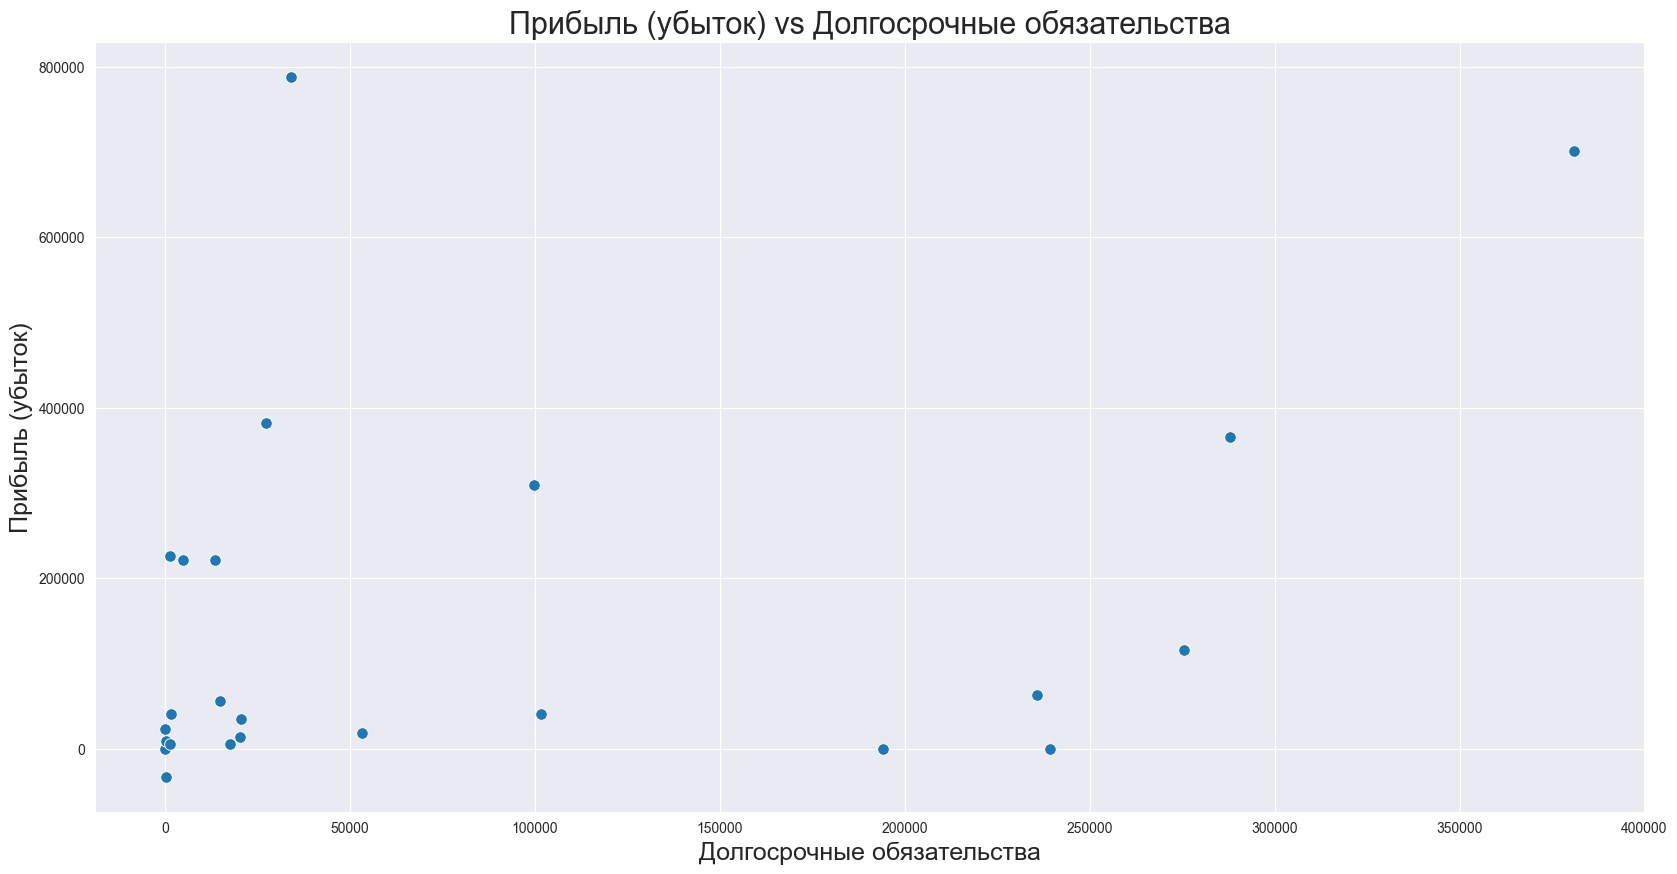

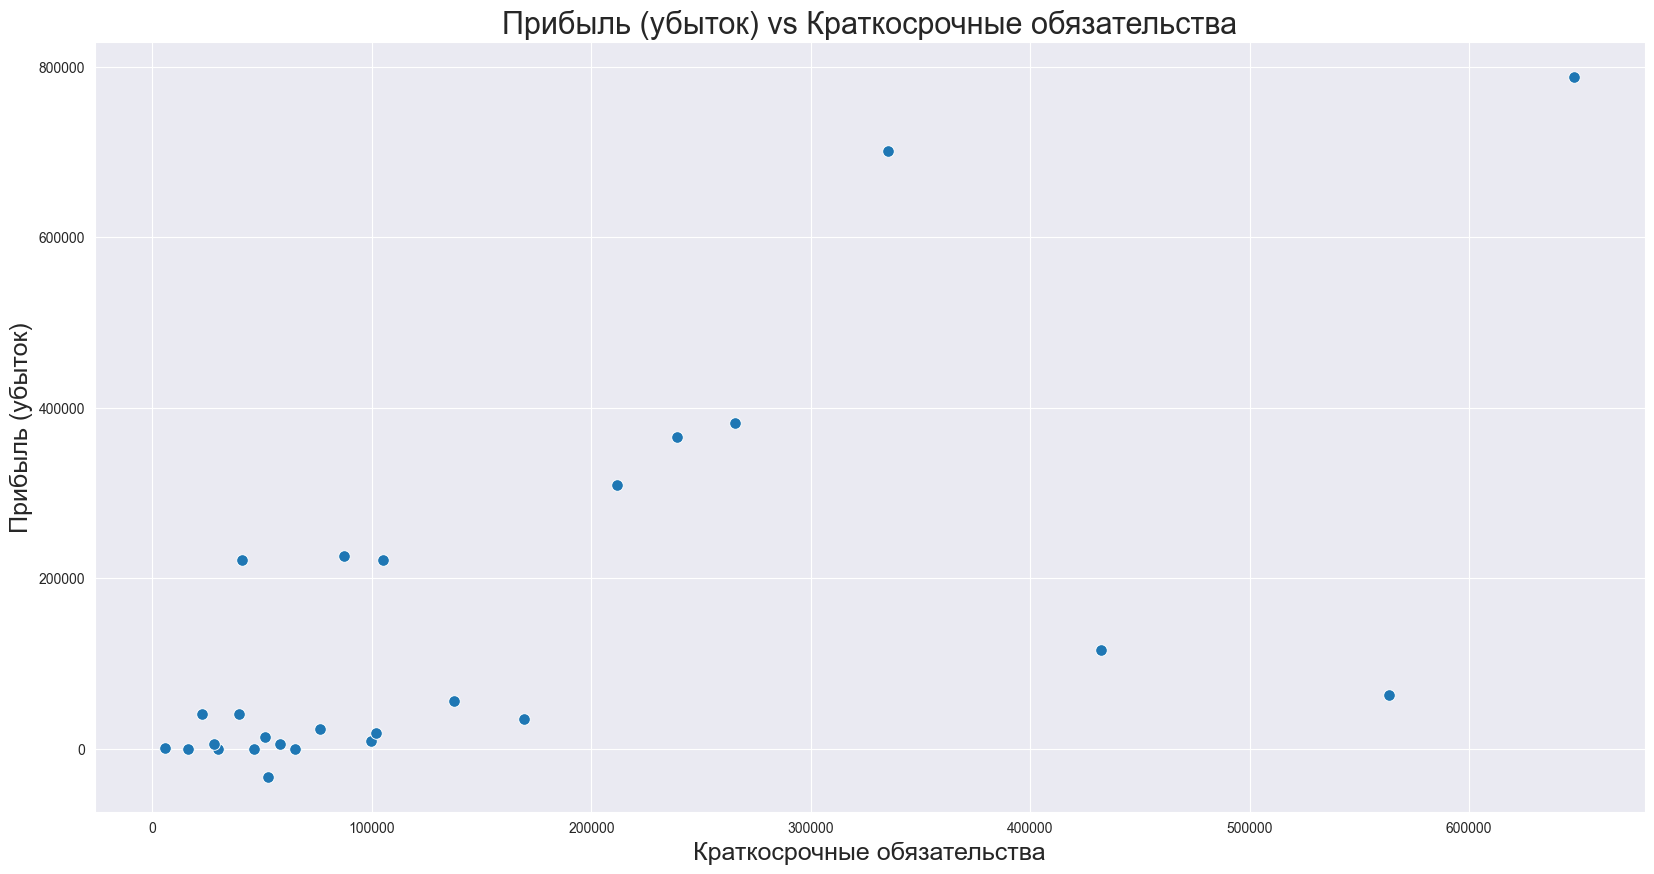

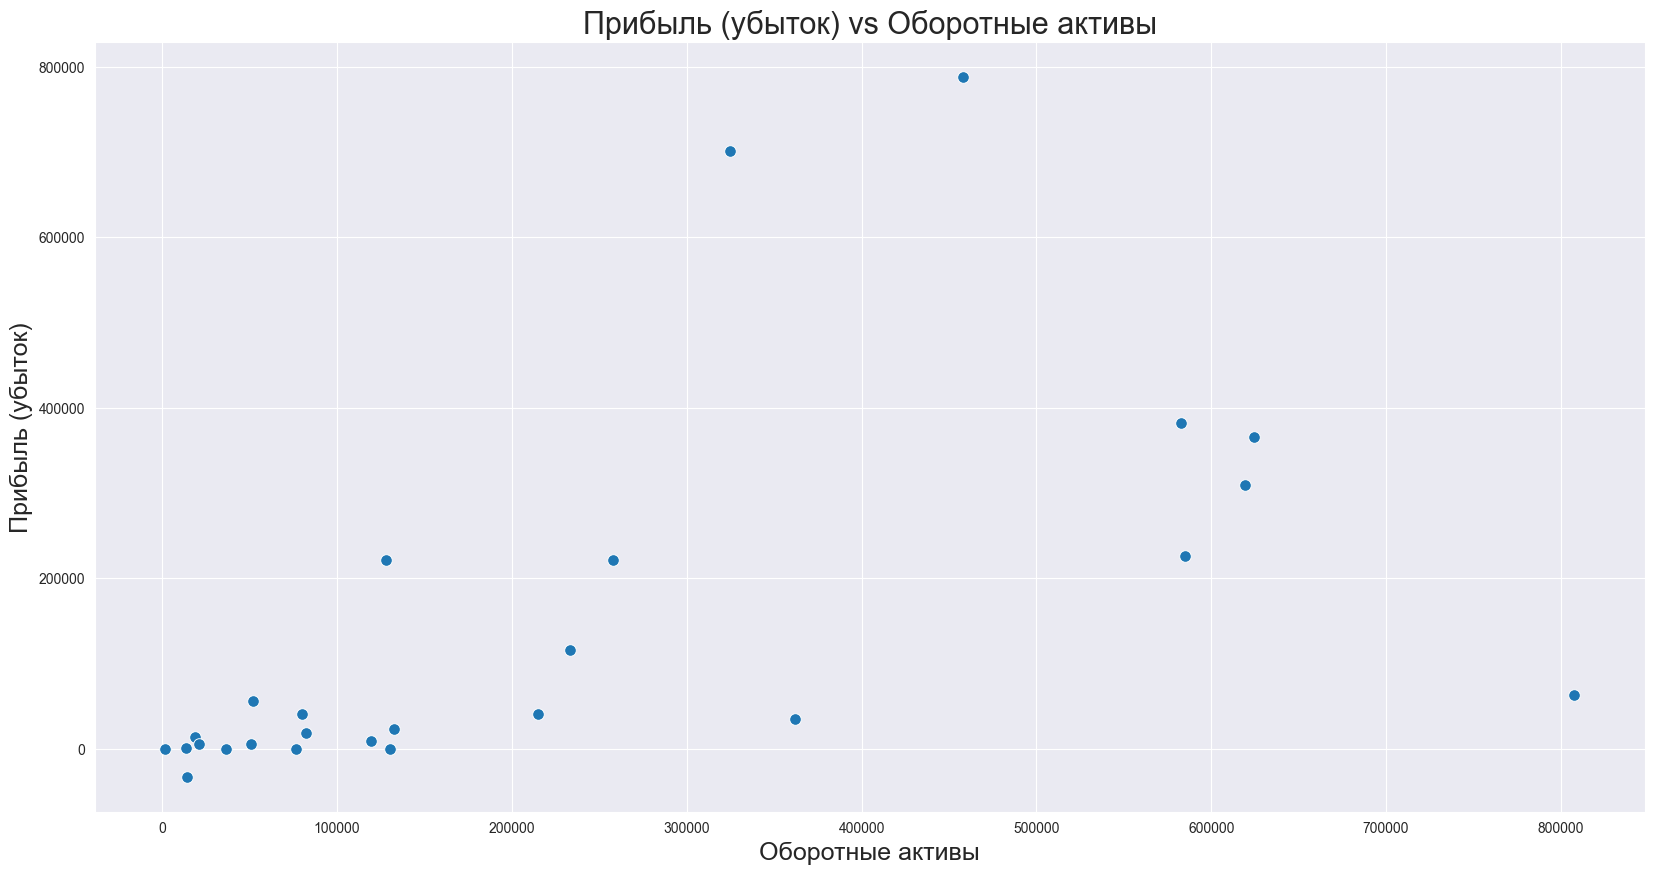

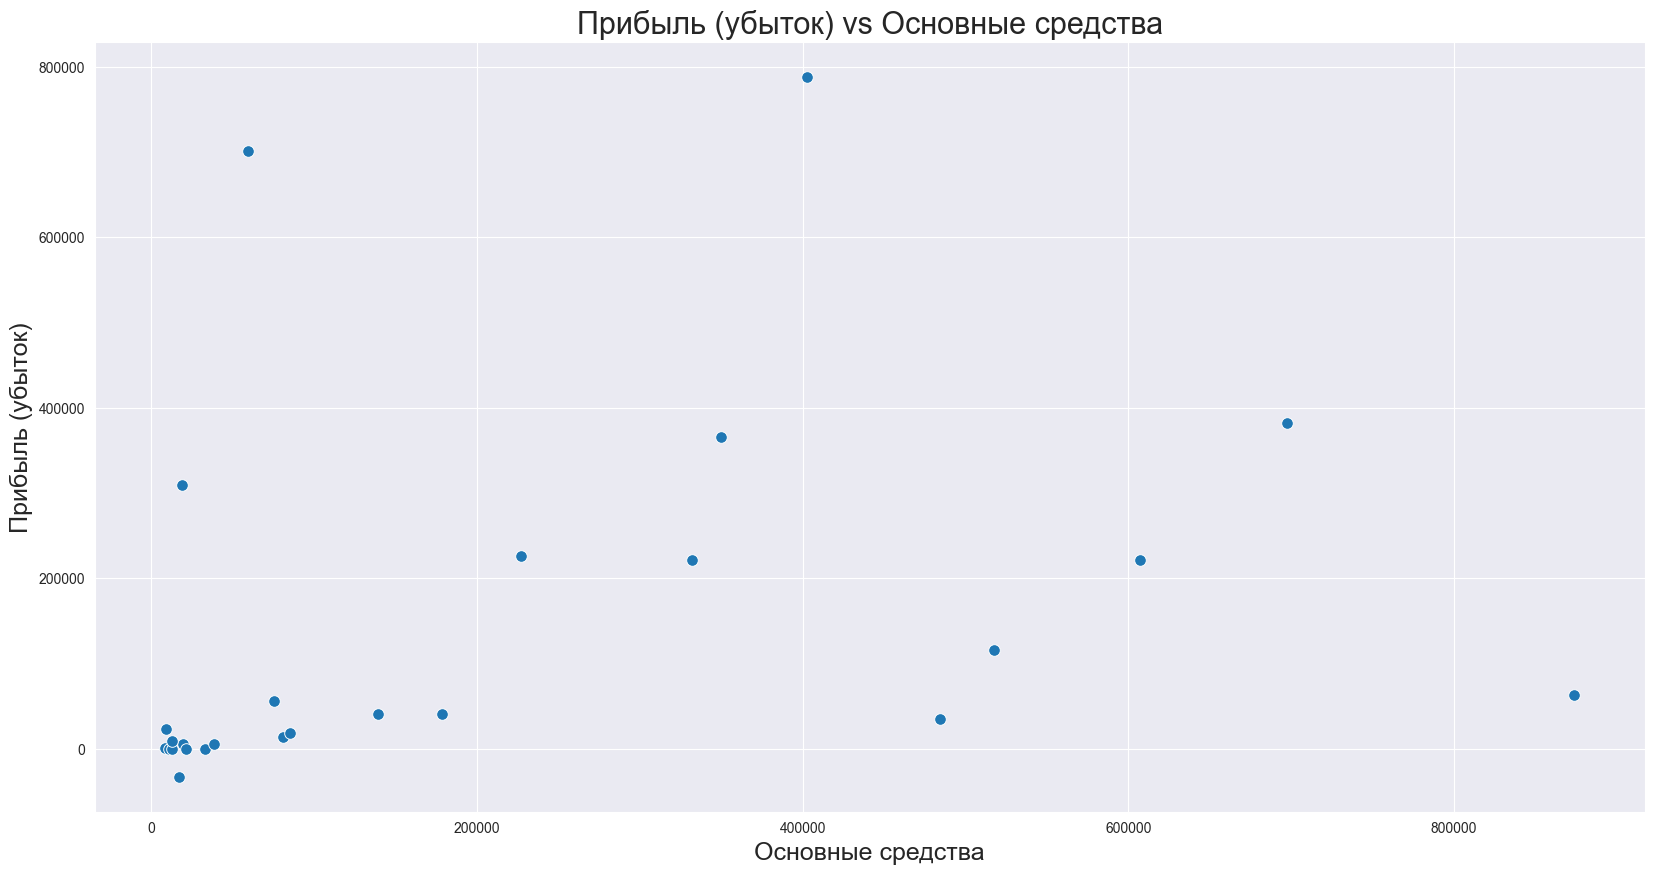

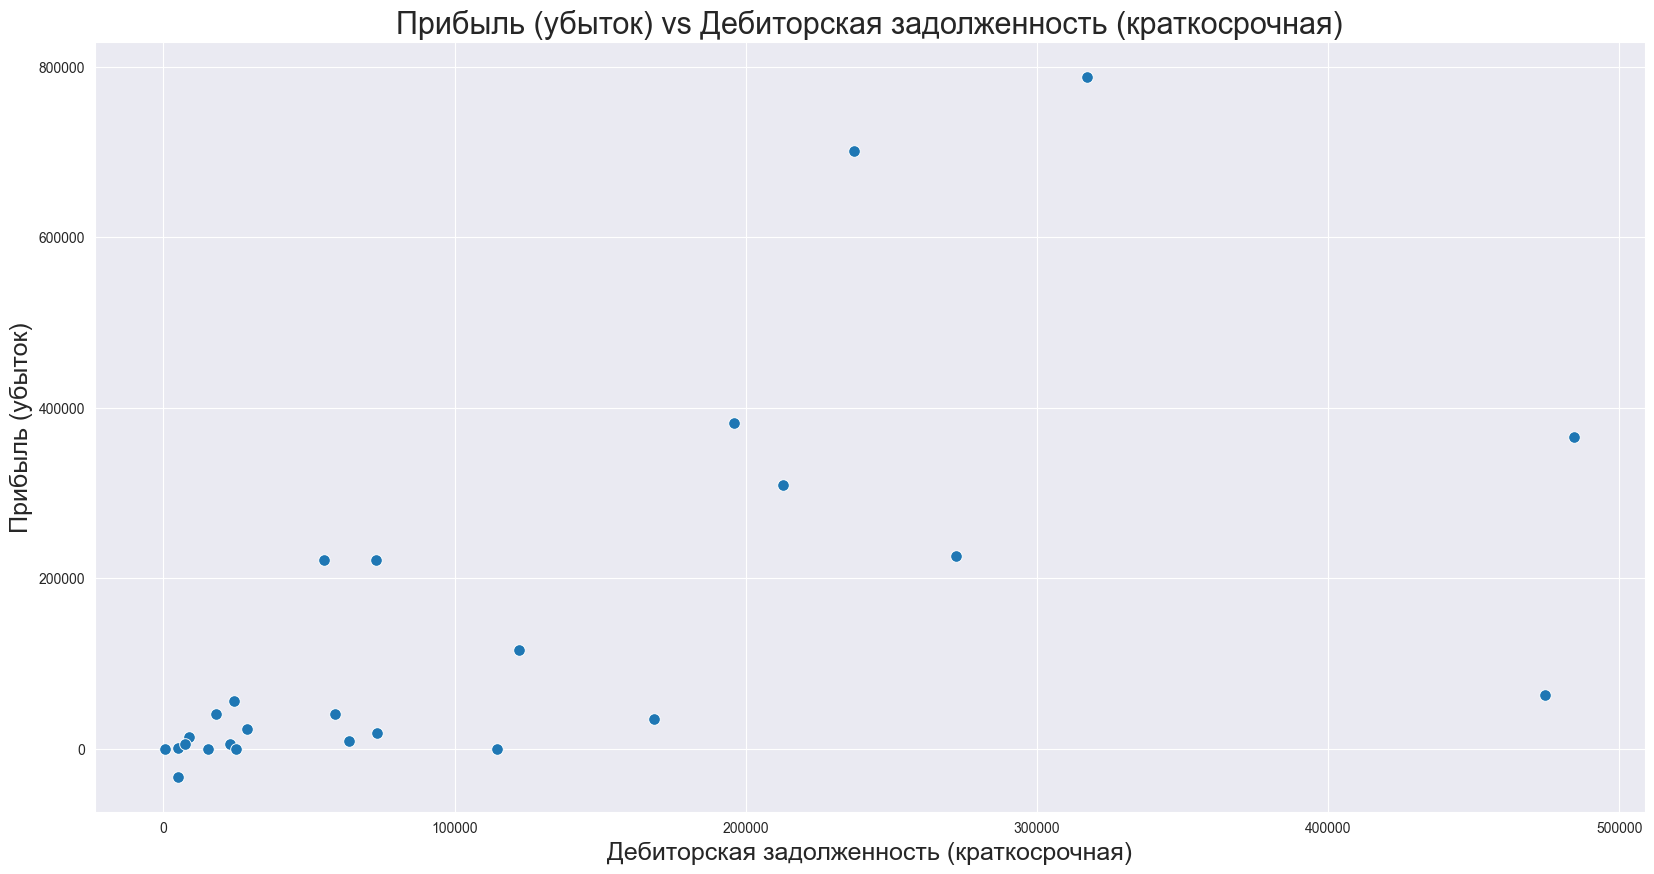

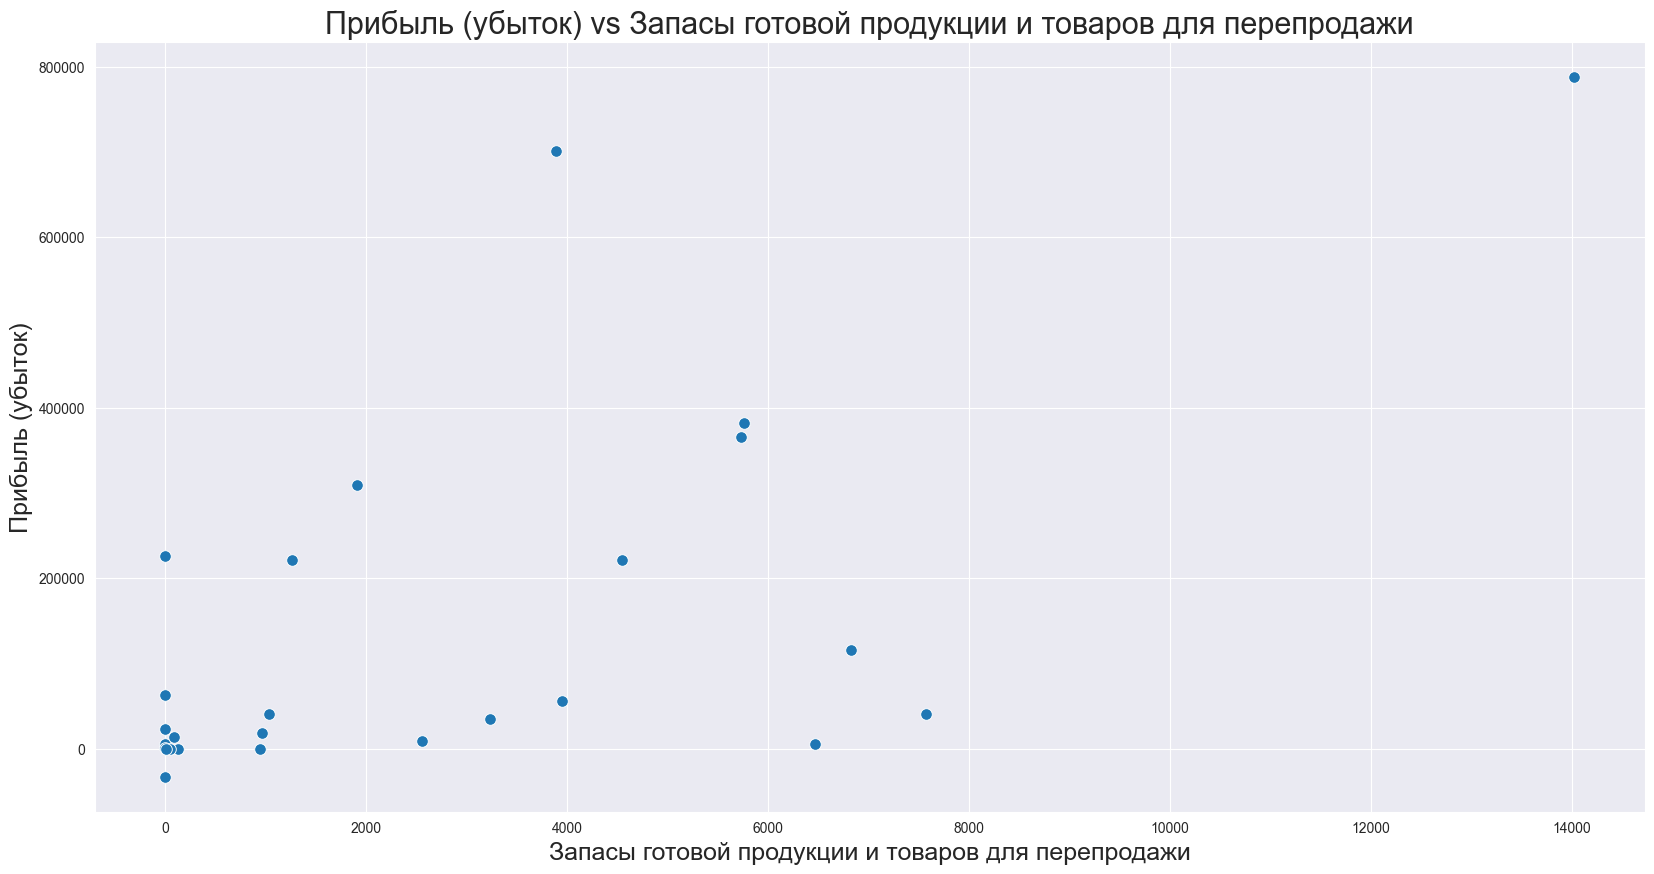

In [37]:
if df_cleaned is not None and not df_cleaned.empty:
    def plot_scatter_separately(data, dependent_var, independent_vars):
        for var in independent_vars:
            plt.figure(figsize=(20, 10))  # Большой размер для полноэкранного вывода
            sns.scatterplot(x=data[var], y=data[dependent_var], s=70)  # Размер маркеров
            plt.xlabel(var, fontsize=18)  # Увеличиваем размер шрифта подписей осей
            plt.ylabel(dependent_var, fontsize=18)
            plt.title(f'{dependent_var} vs {var}', fontsize=22)  # Увеличиваем размер шрифта заголовка
            plt.show()
    
    dependent_variable = 'Прибыль (убыток)'
    independent_variables = [
        'Долгосрочные обязательства',
        'Краткосрочные обязательства',
        'Оборотные активы',
        'Основные средства',
        'Дебиторская задолженность (краткосрочная)',
        'Запасы готовой продукции и товаров для перепродажи'
    ]
    
    # Построение диаграмм рассеяния
    plot_scatter_separately(df_cleaned, dependent_variable, independent_variables)


## Вычисление корреляционной матрицы 


Корреляционная матрица:
                                                    Прибыль (убыток)  \
Прибыль (убыток)                                            1.000000   
Долгосрочные обязательства                                  0.355062   
Краткосрочные обязательства                                 0.665281   
Оборотные активы                                            0.563796   
Основные средства                                           0.321259   
Дебиторская задолженность (краткосрочная)                   0.600290   
Запасы готовой продукции и товаров для перепродажи          0.633228   

                                                    Долгосрочные обязательства  \
Прибыль (убыток)                                                      0.355062   
Долгосрочные обязательства                                            1.000000   
Краткосрочные обязательства                                           0.476712   
Оборотные активы                                                      

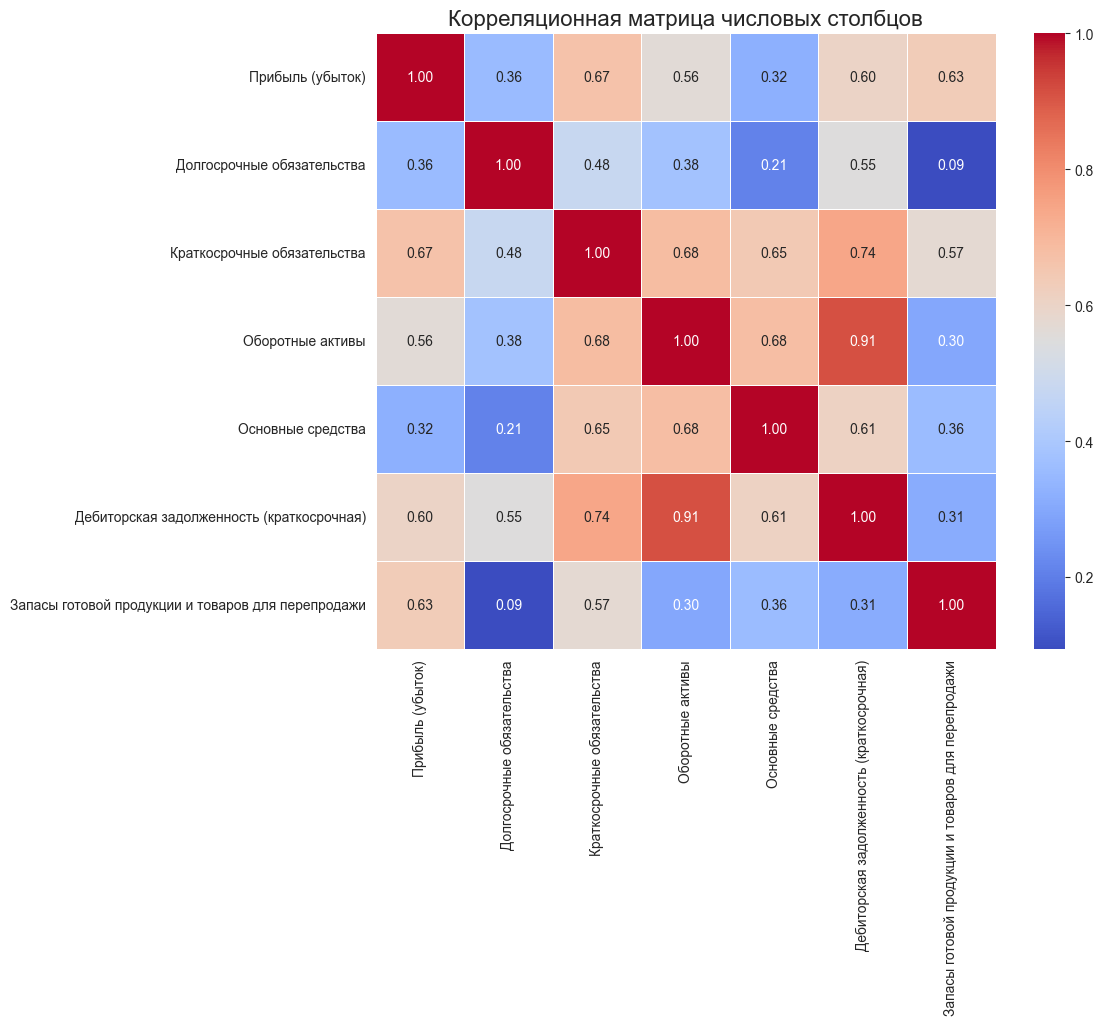

In [38]:

corr_matrix = df_cleaned[numeric_columns].corr()


print("\nКорреляционная матрица:")
print(corr_matrix)



plt.figure(figsize=(10, 8))


sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)


plt.title('Корреляционная матрица числовых столбцов', fontsize=16)


plt.show()


## Метод пошагового отбора признаков - Forward_selection


In [39]:
def forward_selection(data, response, predictors, significance_level=0.05):
    """
    Perform a forward selection based on p-value from statsmodels.api.OLS
    
    Arguments:
        data - pandas DataFrame with all possible predictors and response
        response - string, name of response column in data
        predictors - list of strings, names of predictor columns in data
        significance_level - p-value used to include a variable

    Returns:
        list of selected predictors
    """
    initial_features = []
    best_features = []
    remaining_features = set(predictors)
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            model = sm.OLS(data[response], sm.add_constant(data[initial_features + [candidate]])).fit()
            p_value = model.pvalues[candidate]
            scores_with_candidates.append((candidate, p_value))
        # Select the candidate with the lowest p-value
        scores_with_candidates.sort(key=lambda x: x[1])
        best_candidate, best_p_value = scores_with_candidates[0]
        if best_p_value < significance_level:
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_features = initial_features.copy()
            print(f"Добавлен фактор '{best_candidate}' с p-значением {best_p_value:.4f}")
        else:
            break
    return best_features


In [40]:
# Определение зависимой переменной и списка регрессоров
dependent_variable = 'Прибыль (убыток)'
independent_variables = [
    'Долгосрочные обязательства',
    'Краткосрочные обязательства',
    'Оборотные активы',
    'Основные средства',
    'Дебиторская задолженность (краткосрочная)',
    'Запасы готовой продукции и товаров для перепродажи'
]

# Применение метода пошагового отбора
selected_features = forward_selection(df_cleaned, dependent_variable, independent_variables)

print("\nОтобранные факторы после пошагового отбора:")
print(selected_features)


Добавлен фактор 'Краткосрочные обязательства' с p-значением 0.0002
Добавлен фактор 'Запасы готовой продукции и товаров для перепродажи' с p-значением 0.0403

Отобранные факторы после пошагового отбора:
['Краткосрочные обязательства', 'Запасы готовой продукции и товаров для перепродажи']


## Построение Модели с отобранными факторами


In [41]:
# Построение модели с отобранными факторами
X = sm.add_constant(df_cleaned[selected_features])
y = df_cleaned[dependent_variable]

model = sm.OLS(y, X).fit()

# Вывод результатов модели
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Прибыль (убыток)   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     13.37
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           0.000141
Time:                        21:56:34   Log-Likelihood:                -345.70
No. Observations:                  26   AIC:                             697.4
Df Residuals:                      23   BIC:                             701.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

### Выводы для результатов модели

1. **R squared (R^2)**: 0.538 Интерпретация: Модель объясняет примерно 53.8% вариации прибыли компании. Это означает, что выбранные независимые переменные (факторы) относительно хорошо описывают зависимую переменную (прибыль), но остаётся около 46.2% вариации, не объяснённой моделью.
2. **F-статистика: 13.37 (p-value: 0.000141)**: Очень низкое p-значение свидетельствует о статистической значимости модели в целом. Это означает, что хотя некоторые предикторы могут быть незначимыми, модель как совокупность предикторов существенно предсказывает прибыль.
3. **Краткосрочные обязательства (X1)**:Краткосрочные обязательства являются статистически значимым положительным предиктором прибыли (p < 0.05). Это указывает на то, что увеличение краткосрочных обязательств связано с увеличением прибыли компании. Для каждого увеличения краткосрочных обязательств на единицу прибыль увеличивается в среднем на 0.5696 единиц, при условии фиксированных остальных факторов.
4. **Запасы готовой продукции и товаров для перепродажи (Х6)**: Запасы также являются статистически значимым положительным предиктором прибыли (p < 0.05). Это означает, что увеличение запасов готовой продукции и товаров для перепродажи связано с увеличением прибыли компании. Для каждого увеличения запасов на единицу прибыль увеличивается в среднем на 23.7531 единиц, при условии фиксированных остальных факторов.
5. **Основные выводы**:
Значимость модели: Модель статистически значима (p < 0.05), что подтверждается низким p-значением F-статистики. Это указывает на то, что модель существенно предсказывает прибыль.

Влияние факторов:

Краткосрочные обязательства и запасы готовой продукции и товаров для перепродажи являются значимыми предикторами прибыли. Их увеличение связано с ростом прибыли.
Перехват не значим, что подразумевает отсутствие значимого среднего уровня прибыли при нулевых значениях независимых переменных.
Проблемы модели:

Мультиколлинеарность: Очень высокий коэффициент условности указывает на сильную мультиколлинеарность между предикторами. Это может привести к нестабильности оценок коэффициентов и затруднить интерпретацию влияния отдельных факторов.
Нормальность остатков: Хотя тесты показывают пограничные результаты, остатки в целом не отклоняются существенно от нормального распределения. 
6. **Важно отметить** : у нас всего 26 наблюдений и этот Относительно небольшой размер выборки может ограничивать обобщаемость выводов и повышает риск переобучения модели.